Se define una clase "generador de referencias". Luego se creará un objeto del tipo "generador de referencias" y se incluirá dentro del robot, para que él mismo gener esus propias referencias.

In [ ]:
!pip install mpld3
import mpld3

from mpld3 import plugins

In [ ]:
tf.keras.backend.clear_session()  # Para restablecer fácilmente el estado del portátil.

In [ ]:
!pip install keras==2.6.0
!pip install tensorflow==2.6.0

In [ ]:
!rm -rf output_folder

In [ ]:
# Se importa el modelo del archivo "file.zip"
!unzip "/content/file.zip" -d "/content/output_folder"

In [ ]:
import tensorflow as tf

import numpy as np

class ref_generator():
    def __init__(self):
        
        # se carga el modelo de tensorflow
        self.model = tf.keras.models.load_model("./output_folder/content/saved_models", compile = True)
        # self.model = tf.keras.models.load_model("./output_folder/content/tmp/model", compile = True)
        
        # cantidad de entradas de la red neuronal
        # n_input = 6
        
        # cantidad de puntos futuros deseadosque se le cargan a la red
        # neuronal
        self.L = 2
        
    def get_reference(self,trajectory,n_ref,current_pos):
        
        # a partir de la trayectoria y de la pose actual, se genera el vector
        # de entrada para la red neuronal
        #pdb.set_trace()

        current = np.array(current_pos)
        current_aux = np.copy(current)
        current_aux.shape = (3,1)
        if n_ref + self.L <= trajectory.shape[1]:
          desired = np.copy(trajectory[:,n_ref:n_ref+self.L])
          desired[0:2,:] = desired[0:2,:] - current_aux[0:2,:]
          desired = np.reshape(desired,(self.L * 3,),'F')
        
        else:
          #pdb.set_trace()
          desired = np.copy(trajectory[:,n_ref])
          desired[0:2] = desired[0:2] - current[0:2]
          # desired.shape = (3*self.L,)
          #print(n_ref)
          i = 0
          for i in range(0,trajectory.shape[1] - n_ref - 1):
            aux = np.copy(trajectory[:,n_ref + i + 1])
            aux[0:2] = aux[0:2] - current[0:2]
            desired = np.hstack((desired,aux))
          
          if (n_ref == trajectory.shape[1] - 1):
            i = 0
            aux = np.copy(trajectory[:,n_ref])
            aux[0:2] = aux[0:2] - current[0:2]
            for j in range(i,self.L-1):
              desired = np.hstack((desired,aux))

          else:
            for j in range(i,self.L-2):
              desired = np.hstack((desired,aux))

        
        # genero el vector de pose actual del robot, para luego introducirlo
        # en la red neuronal
        # pdb.set_trace()
        # current = np.array(current_pos)
        # desired = desired - current_aux
        current[0:2] = current[0:2] - current[0:2]
        
        # junto la deseada con la actual para generar la entrada a la red
        # neuronal
        # pdb.set_trace()
        for k in range(0,self.L):
          angle = desired[3 * k + 2 ] + 2 * np.pi
          desired[3 * k + 2] = angle
        
        current[2] = current[2] + 2 * np.pi
        input_states = np.hstack((current,desired))
        input_states = np.expand_dims(input_states, axis = 0)
#===============================================================================
# Esto es válido solo para la entrada diferencial
#         current = np.array(current_pos)
#        p_t = current[0:2]
#        theta_t = current[2]

#        p_d_1 = desired[0:2]
#        theta_d_1 = desired[2]

#        input_states = np.hstack((p_d_1 - p_t,theta_t,theta_d_1))
#===============================================================================

        # input_states = np.expand_dims(input_states, axis = 0)
        
        # genero la nueva referencia
        new_reference = self.model.predict(input_states)
        
        new_reference.shape = (2,)
#===============================================================================
# Esto es válido solo para la entrada diferencial
        # new_reference = new_reference + p_d_1
#===============================================================================
        return ( new_reference + np.array(current_pos[0:2]) )

In [ ]:
trajectory[:,19]


Se define una clase robot

In [ ]:
import numpy as np

import threading
import time
import timeit

from clase_PID import PID
from clase_PID import calculate_references

# from reference_generator import ref_generator

class Robot():
    def __init__(self,x=0,y=0,theta=0,dt = 0.1, dt_control = 0.5):
        
        # posición real del robot
        self.__ground_truth = (x,y,theta)
        self.__odometry = (x,y,theta)


		# dimensiones del robot
        self.r = 0.036
        self.l = 0.235
        self.height = 0.10
        self.diameter = 0.35

		# velocidades del robot
        self.__v = 0
        self.__w = 0
        
        # velocidades máximas y mínimas
        self.__v_max = 2.0
        self.__v_min = -2.0
        #self.__v_max = 1000
        #self.__v_min = -1000
         
        # velocidades máximas y mínimas
        self.__w_max = 5.0
        self.__w_min = -5.0
        #self.__w_max = 1000
        #self.__w_min = -1000

		#Error parameters
		# self.alpha = (0.10, 0.20, 0.10, 0.20, 0.25, 0.25)
        alpha = [0.10, 0.20, 0.10, 0.20, 0.25, 0.25]
        multiplicador = 2
        alpha = [a * multiplicador for a in alpha]
        self.alpha = tuple(alpha)
        
        # configuración del simulador del robot móvil
        self.__simulation_mobile_robot_on = False # indica si la simulación está corriendo o no
        self.__simulation_mobile_robot_thread = threading.Thread(target = self.__simulation_task_mobile_robot)
        self.dt = dt
        
        
        # configuración del simulador del controlador
        self.__simulation_control_on = False
        self.__simulation_control_thread = threading.Thread(target = self.__simulation_task_control)
        self.dt_control = dt_control
        self.__step_counter_control = 0
        
	# setters
	# setear la velocidad lineal
    def set_linear_velocity(self,v):
        if(v > self.__v_max):
            self.__v = self.__v_max
        elif(v < self.__v_min):
            self.__v = self.__v_min
        else:
            self.__v = v

	# setear la velocidad angular
    def set_angular_velocity(self,w):
        if(w > self.__w_max):
            self.__w = self.__w_max
        elif(w < self.__w_min):
            self.__w = self.__w_min
        else:
            self.__w = w
    
    # getters
	# obtener la velocidad lineal
    def get_linear_velocity(self):
        return self.__v

	# obtener la velocidad angular
    def get_angular_velocity(self):
        return self.__w

	# obtener el ground truth del robot
    def get_ground_truth(self):
        return self.__ground_truth
    
    def get_odometry(self):
        return self.__odometry
    
    def get_real_trajectory(self):
        return self.__real_trajectory
    
    def get_references_DNN(self):
        return self.__references_DNN
      
    def get_max_linear_velocity(self):
        return self.__v_max, self.__v_min
      
    def get_max_angular_velocity(self):
        return self.__w_max, self.__w_min
    
    #private methods
    def __sample_nd(self, b):
        return (b / 6.0) * np.sum(2.0 * np.random.rand(12) - 1.0)

	# movimiento del robot
    def move(self):
        
        v = self.__v
        w = self.__w

        if(w != 0):
            v_w = v/w
            next_x = self.__odometry[0] - v_w * np.sin(self.__odometry[2]) + v_w * np.sin(self.__odometry[2] + w * self.dt)
            next_y = self.__odometry[1] + v_w * np.cos(self.__odometry[2]) - v_w * np.cos(self.__odometry[2] + w * self.dt)
            next_theta = self.__odometry[2] + w * self.dt

        else:
            next_x = self.__odometry[0] + v * np.cos(self.__odometry[2]) * self.dt
            next_y = self.__odometry[1] + v * np.sin(self.__odometry[2]) * self.dt
            next_theta = self.__odometry[2]
		
        next_odom = (next_x,next_y,next_theta)
        self.__odometry = next_odom
        
        v_hat = v + self.__sample_nd(self.alpha[0] * np.abs(v) + self.alpha[1] * np.abs(w))
        w_hat = w + self.__sample_nd(self.alpha[2] * np.abs(v) + self.alpha[3] * np.abs(w))
        gamma_hat = self.__sample_nd(self.alpha[4] * np.abs(v) + self.alpha[5] * np.abs(w))
        
        if(w_hat != 0):
            v_w = v_hat/w_hat
            next_x = self.__ground_truth[0] - v_w * np.sin(self.__ground_truth[2]) + v_w * np.sin(self.__ground_truth[2] + w_hat * self.dt)
            next_y = self.__ground_truth[1] + v_w * np.cos(self.__ground_truth[2]) - v_w * np.cos(self.__ground_truth[2] + w_hat * self.dt)
            next_theta = self.__ground_truth[2] + w_hat * self.dt + gamma_hat * self.dt

        else:
            next_x = self.__ground_truth[0] + v_hat * np.cos(self.__ground_truth[2]) * self.dt
            next_y = self.__ground_truth[1] + v_hat * np.sin(self.__ground_truth[2]) * self.dt
            next_theta = self.__ground_truth[2] + gamma_hat * self.dt

		# se normaliza la orientación del robot, para obtener un número entre -pi y pi
        while(next_theta > np.pi):
            next_theta = next_theta - 2 * np.pi

        while(next_theta <= -np.pi):
            next_theta = next_theta + 2 * np.pi


		# se setea la nueva pose del robot
        next_pos = (next_x,next_y,next_theta)

        self.__ground_truth = next_pos
        
# Métodos del trajectory follower

# Configuración del seguidor de trayectorias
    #def trajectory_follow_config(self,Kp,Ti,Td,trajectory):
    def trajectory_follow_config(self,Kp_s,Kp_theta,trajectory):
        
        # se crea el generador de referencias que se utilizará para
        # controlar la trayectoria
        self.ref_gen = ref_generator()
        
        # se crean los PIDs para el seguimiento de trayectoria
        self.PID_theta = PID(Kp_theta,0,0,self.dt_control)
        self.PID_s = PID(Kp_s,0,0,self.dt_control)
        
        # se carga la trayectoria a seguir
        self.trajectory = trajectory
        self.trajectory_len = np.shape(trajectory)[1]
        
        # se setea la primer referencia
        self.n_ref = 0
        #self.n_ref = 1
        # self.reference = trajectory[:,0]
        self.reference = self.ref_gen.get_reference(self.trajectory,self.n_ref,self.__ground_truth)
        
        # contador que sirve para saber cuándo modificar la referencia del
        # controlador
        self.reference_change_counter = 0
        self.reference_change_counter_max = 3
        
        self.trajectory_follow_activated = False
        
        # se crea una lista vacía que contendrá todas las poses de las 
        # trayectorias que irá recorriend el robot
        #self.__real_trajectory = [self.__ground_truth]
        self.__real_trajectory = []

        # se crea otra listaque contendrá las referencias que generó la red 
        # neuronal
        self.__references_DNN = []
        
# Cálculo de la acción de control del seguidor de trayectorias        
    def trajectory_follow(self):
        
        #if self.trajectory_follow_activated == False:
          #self.set_linear_velocity(0)
          #self.set_angular_velocity(0)
        
        #else:

        # Se calculan las referencias auxiliares
        # aux_reference = self.ref_gen.get_reference(self.trajectory,self.n_ref,self.__ground_truth) 
        
        # aux_reference = self.reference

        
        #aux_reference = np.array(aux_reference)
        #aux_reference.shape = (2,1)
        
        # A partir de la referencia en la trayectoria y de la posición actual,
        # se calculan los errores
        e_theta, e_s = calculate_references(self.reference,self.__ground_truth)
        # e_theta, e_s = calculate_references(aux_reference,self.__ground_truth)
        
        # Se calculan las velocidades lineal y angular
        w = self.PID_theta.control(e_theta)
        v = self.PID_s.control(e_s)
        
        # Se setean en el robot
        self.set_linear_velocity(v)
        self.set_angular_velocity(w)
        
        self.reference_change_counter +=1
        
        if self.reference_change_counter == self.reference_change_counter_max:
            # se setea la próxima referencia
            self.n_ref = self.n_ref + 1
            self.reference_change_counter = 0
            self.__real_trajectory.append(self.__ground_truth)
            self.__references_DNN.append(self.reference)
        
            if self.n_ref < self.trajectory_len:
                # self.reference = self.trajectory[:,self.n_ref]
                self.reference = self.ref_gen.get_reference(self.trajectory,self.n_ref,self.__ground_truth)
                
            
            else:
                self.trajectory_follow_activated = False

# =============================================================================
# Métodos de la simulación
# =============================================================================
# Simulation task: ejecuta el paso de simulación del robot móvil
    def __simulation_task_mobile_robot(self):
        
        while self.__simulation_mobile_robot_on == True:
            
            # se incrementa en uno el contador de veces que se invocó al
            # paso de simulación de control
            self.__step_counter_mobile_robot += 1
            
            # tiempo que tarda en ejecutarse la función que mueve al robot            
            time_for_moving = timeit.timeit(self.move, number = 1)
            
            time_to_sleep = self.dt - time_for_moving
            
            if time_to_sleep > 0:
                time.sleep(time_to_sleep)
                
            else:
                time.sleep(0.010)
        
        return

# Simulation task: ejectua el controlador para calcular la velocidad lineal y
# angular del robot
    def __simulation_task_control(self):
        
        while self.__simulation_control_on == True:
            
            self.__step_counter_control += 1
            
            # tiempo que tarda en ejecutarse la función que mueve al robot
            time_for_controlling = timeit.timeit(self.trajectory_follow, number = 1)
            
            time_to_sleep = self.dt_control - time_for_controlling
            
            if time_to_sleep > 0:
                time.sleep(time_to_sleep)
            
            else:
                time.sleep(0.010)
        
        return

    # Simulation start: inicial as imulación del movimiento del robot
    def start_simulation_robot(self):
        
        self.__step_counter_mobile_robot = 0
        self.__elapsed_time_mobile_robot = 0
        self.__simulation_mobile_robot_on = True
        self.__simulation_mobile_robot_thread.start()
    
    def stop_simulation_robot(self):
        
        self.__simulation_mobile_robot_on = False
        self.__simulation_mobile_robot_thread.join()
        print("Robot: simulation stopped")
    
    # Simulation start: inicial as imulación del movimiento del trajectory follow
    def start_simulation_control(self):
        
        self.__step_counter_control = 0
        self.__elapsed_time_control = 0
        self.__simulation_control_on = True
        self.trajectory_follow_activated = True
        self.__simulation_control_thread.start()
    
    def stop_simulation_control(self):
        
        self.__simulation_control_on = False
        self.__simulation_control_thread.join()
        print("Control: simulation stopped")

# Simulation start:inicia la simulación de todo
    def start_simulation(self):
            
        self.start_simulation_robot()
        self.start_simulation_control()

# Stop simulation: detiene la simulación de todo
    def stop_simulation(self):
        
        if self.__simulation_mobile_robot_on == True:
            self.stop_simulation_robot()
            
        if self.__simulation_control_on == True:
            self.stop_simulation_control()

# Devuelve el contador de la simulación del robot móvil
    def get_simulation_step_counter_mobile_robot(self):
        return self.__step_counter_mobile_robot

# Devuelve el tiempo de la simulación del robot móvil
    def get_simulation_time_mobile_robot(self):
        return self.__step_counter_mobile_robot * self.dt

# Devuelve el contador de la simulación del controlador
    def get_simulation_step_counter_control(self):
        return self.__step_counter_control

# Devuelve el tiempo de la simulación del robot controlador
    def get_simulation_time_control(self):
        return self.__step_counter_control * self.dt_control
    

In [ ]:
# Imports

import numpy as np
import matplotlib.pyplot as plt

# "pdb" es una biblioteca que sirve para debuggear el código. Ver el cheatsheet en: 
# https://appletree.or.kr/quick_reference_cards/Python/Python%20Debugger%20Cheatsheet.pdf

import pdb

from ploteo_del_robot import *

from curve_equally_spaced import *

In [ ]:
# Utilidades
import numpy as np

def length_trajectory(T):
    
    N = T.shape[1]
    
    l = 0
    
    for i in range(1,N):
        #pdb.set_trace()
        t1 = T[0:2,i]
        t0 = T[0:2,i-1]

        delta_l = np.linalg.norm(t1 - t0)
        
        l += delta_l
    
    return l
"""
==============================================================================
Calculate error:

    c: variable de tipo np.array, de 2 filas x N columnas. Contiene la
       trayectoria recorrida por el robot.
    
    d: variable de tipo np.array, de 2 x N. Contiene la trayectoria deseada,

    La columna t del vector "c" contiene la posición donde se encontró al robot
    en ese instante. La columna t del vector "d" contiene la posición donde se
    quería encontrar al robot. 
    
    La función devuelve el E_RMS entre ambas trayectorias y el E_peak, siendo 
    este último la distancia máxima entre un punto deseado en algún instante t,
    y el correspondiente punto donde se encontró al robot.

============================================================================="""
def calculate_error(c,d):
    #pdb.set_trace()
    N = np.shape(d)[1]
    e = 0
    e_peak = 0

    for i in range(N):
        c_aux = np.array(c[i][0:2])
        # c_aux.shape = (2,1)
        e_new = np.linalg.norm(c_aux - d[0:2,i])
        
        if(e_new > e_peak):
            e_peak = e_new
            
        e = e + e_new**2
        # e_peak
    
    e = e / N
    
    e_rms = np.sqrt(e)
    
    return e_rms, e_peak
        
"""
==============================================================================
Create trajectory:

    N: cantidad de puntos que tendrá la trayectoria creada.

    Devuelve una trayectoria en el plano xy a ser recorrida por el robot, de 
    "N" puntos. Las características de la trayectoria dependen de la función que
    se encuentre descomentada.

============================================================================="""        
def create_trajectory(N):
    
    # trayectoria lineal
    # return linear_trajectory(N)
    
    # trayectoria circunferencia
    # return circle_trajectory(N)

    # trayectoria cuadrada comenzando en horizontal
    return square_trajectory(N)

    # trayectoria cuadrada comenzando en vertical
    # return square_trajectory_y(N)

    # trayectoria con forma de señal cuadrada en el plano xy
    # return labyrinth_trajectory(N)

    # trayectoria en espiral
    # return spiral_trajectory(N)

    # return spiral_trajectory_2(N)
    # trayectoria que es como una sinusoidal rectificada
    # return curvy_trajectory(N)

"""
==============================================================================
Linear trajectory:

    N: cantidad de puntos que tendrá la trayectoria creada.

    Devuelve una trayectoria en línea recta horizontal. La trayectoria comienza
    en el punto (0,1) y finaliza en (10,1). La trayectoria siempre es de "N"
    puntos!

============================================================================="""  
def linear_trajectory(N):

    # devuelve un array de posiciones (x,y) que definen la trayectoria a seguir
    # la trayectoria será de N puntos en el plano
    trajectory_x = np.linspace(0,30,N)
    trajectory_y = np.ones(trajectory_x.shape) * 0
    # trajectory = np.stack((trajectory_x,trajectory_y))

        # calculo los ángulos de las poses
    angulos = []
    for i in range(N-1):
        theta = np.arctan2((trajectory_y[i+1] - trajectory_y[i]),(trajectory_x[i+1] - trajectory_x[i]))
        angulos.append(theta)
    
    angulo_N = angulos[N-2]
    angulos.append(angulo_N)
    angulos_vector = np.array(angulos)
    
    trajectory = np.stack((trajectory_x,trajectory_y,angulos_vector))
    
    return trajectory

def circle_trajectory(N):
    radio = 10
    center = np.array([10,10])
    angle = np.linspace(0,2*np.pi,N)
    trajectory_x = np.ones(N) * center[0] + radio * np.cos(angle)
    trajectory_y = np.ones(N) * center[1] + radio * np.sin(angle)
    trajectory = np.stack((trajectory_x,trajectory_y))
    
    # calculo los ángulos de las poses
    angulos = []
    for i in range(N-1):
        theta = np.arctan2((trajectory_y[i+1] - trajectory_y[i]),(trajectory_x[i+1] - trajectory_x[i]))
        angulos.append(theta)
    
    angulo_N = angulos[N-2]
    angulos.append(angulo_N)
    angulos_vector = np.array(angulos)
    
    trajectory = np.stack((trajectory_x,trajectory_y,angulos_vector))
    return trajectory

"""
==============================================================================
Square trajectory:

    N: cantidad de puntos que tendrá la trayectoria creada.

    Devuelve una trayectoria cuadrada de N puntos. El punto inicial es el (0,0)
    siguiendo hacia el punto (lado,0), luego (lado,lado), (0,lado) y regresando
    al (0,0). "lado" es una variable que se define dentro de esta función.
    La trayectoria siempre es de "N" puntos!

============================================================================="""  
def square_trajectory(N):
    
    n = int(N/4)
    #diff = 10/(n-1)
    #lado = 20
    lado = 10

    p = lado*4 / N
    """
    primer_tramo_x = np.linspace(0,lado,n)
    primer_tramo_y = np.zeros(n)

    segundo_tramo_x = np.ones(n) * lado
    segundo_tramo_y = np.linspace(0,lado,n)

    tercer_tramo_x = np.linspace(lado,0,n)
    tercer_tramo_y = np.ones(n) * lado    

    cuarto_tramo_x = np.zeros(n)
    cuarto_tramo_y = np.linspace(lado,0,n)
    """
    primer_tramo_x = np.arange(0,lado,p)
    primer_tramo_y = np.zeros( np.shape(primer_tramo_x)[0] )
    #primer_tramo_angulos = np.zeros(np.shape(primer_tramo_x)[0])

    segundo_tramo_y = np.arange(0,lado,p)
    segundo_tramo_x = np.ones( np.shape(segundo_tramo_y)[0] ) * lado
    #segundo_tramo_angulos = np.ones( np.shape(primer_tramo_x)[0] ) * np.pi/2

    tercer_tramo_x = np.arange(lado,0,-p)
    tercer_tramo_y = np.ones(np.shape(primer_tramo_x)[0] ) * lado
    #tercer_tramo_angulos = np.ones( np.shape(primer_tramo_x)[0] ) * np.pi

    cuarto_tramo_y = np.arange(lado,0,-p)
    cuarto_tramo_x = np.zeros( np.shape(cuarto_tramo_y)[0] )
    #cuarto_tramo_angulos = np.ones( np.shape(primer_tramo_x)[0] ) * (-1) * np.pi/2
    
    trajectory_x = np.concatenate((primer_tramo_x,segundo_tramo_x,tercer_tramo_x,cuarto_tramo_x))
    trajectory_y = np.concatenate((primer_tramo_y,segundo_tramo_y,tercer_tramo_y,cuarto_tramo_y))
    trajectory = np.stack((trajectory_x,trajectory_y))
    #trajectory_angulos = np.concatenate((primer_tramo_angulos, segundo_tramo_angulos, tercer_tramo_angulos, cuarto_tramo_angulos))
    #trajectory = np.stack((trajectory_x,trajectory_y,trajectory_angulos))
    
    
    # calculo los ángulos de las poses
    angulos = []
    for i in range(N-1):
        theta = np.arctan2((trajectory_y[i+1] - trajectory_y[i]),(trajectory_x[i+1] - trajectory_x[i]))
        angulos.append(theta)
    
    angulo_N = angulos[N-2]
    angulos.append(angulo_N)
    angulos_vector = np.array(angulos)
    
    trajectory = np.stack((trajectory_x,trajectory_y,angulos_vector))
    
    return trajectory

"""
==============================================================================
Square trajectory y:

    N: cantidad de puntos que tendrá la trayectoria creada.

    Devuelve una trayectoria cuadrada de N puntos. El punto inicial es el (0,0)
    siguiendo hacia el punto (0,lado), luego (lado,lado), (lado,0) y regresando
    al (0,0). "lado" es una variable que se define dentro de esta función.
    La trayectoria siempre es de "N" puntos!

============================================================================="""   
def square_trajectory_y(N):
    
    n = int(N/4)
    #diff = 10/(n-1)

    lado = 10
    
    primer_tramo_x = np.zeros(n)
    primer_tramo_y = np.linspace(0,lado,n)
    primer_tramo_angulos = np.ones(n) * np.pi/2
    
    segundo_tramo_x = np.linspace(0,lado,n)
    segundo_tramo_y = np.ones(n) * lado
    segundo_tramo_angulos = np.zeros(n)
    
    tercer_tramo_x = np.ones(n) * lado
    tercer_tramo_y = np.linspace(lado,0,n)
    tercer_tramo_angulos = np.ones(n) * (-np.pi/2)

    #tercer_tramo_x = np.ones(int(n/2)) * 10
    #tercer_tramo_y = np.linspace(10,5,int(n/2))
    
    cuarto_tramo_x = np.linspace(lado,0,n)
    cuarto_tramo_y = np.zeros(n)
    cuarto_tramo_angulos = np.ones(n) * (-np.pi)

    #cuarto_tramo_x = np.linspace(10,0,n)
    #cuarto_tramo_y = np.ones(n) * 5
    
    trajectory_x = np.concatenate((primer_tramo_x,segundo_tramo_x,tercer_tramo_x,cuarto_tramo_x))
    trajectory_y = np.concatenate((primer_tramo_y,segundo_tramo_y,tercer_tramo_y,cuarto_tramo_y))
    trajectory_angulos = np.concatenate((primer_tramo_angulos, segundo_tramo_angulos, tercer_tramo_angulos, cuarto_tramo_angulos))
    trajectory = np.stack((trajectory_x,trajectory_y,trajectory_angulos))
    
    N = np.shape(trajectory)[1]

    """    
    # calculo los ángulos de las poses
    angulos = []
    for i in range(N-1):
        theta = np.arctan2((trajectory_y[i+1] - trajectory_y[i]),(trajectory_x[i+1] - trajectory_x[i]))
        angulos.append(theta)
    
    angulo_N = angulos[N-2]
    angulos.append(angulo_N)
    angulos_vector = np.array(angulos)
    """


    # trajectory = np.stack((trajectory_x,trajectory_y,angulos_vector))
    return trajectory

"""
==============================================================================
Labyrinth trajectory :

    N: cantidad de puntos que tendrá la trayectoria creada.

    Devuelve una trayectoria que une los siguientes puntos con segmentos:
    (0,0)            --> (0,lado_y)
    (0,lado_y)       --> (lado_x, lado_y)
    (lado_x, lado_y) --> (lado_x, 0)
    (lado_x, 0)      --> (2 * lado_x, 0)
    
    Esto se repite 5 veces.

============================================================================="""   
def labyrinth_trajectory(N):

  lado_y = 20

  lado_x = 5

  M = 5

  N_aux = N/M

  l = (lado_x + lado_y) * 2

  n_horizontal = int(N_aux * lado_x/l)+1

  n_vertical = int(N_aux * lado_y/l)

  print(n_horizontal,n_vertical)
  # pdb.set_trace()
  # 1era parte vertical
  path_1_x = np.zeros(n_vertical)[0:n_vertical-1]
  path_1_y = np.linspace(0,lado_y,n_vertical)[0:n_vertical-1]

  # 2da parte horizontal
  path_2_x = np.linspace(0,lado_x,n_horizontal)[0:n_horizontal-1]
  path_2_y = ( np.ones(n_horizontal) * lado_y )[0:n_horizontal-1]

  # 3era parte vertical
  path_3_x = ( np.ones(n_vertical) * lado_x )[0:n_vertical-1]
  path_3_y = np.linspace(lado_y,0,n_vertical)[0:n_vertical-1]

  # 4ta parte horizontal
  path_4_x = np.linspace(lado_x,lado_x * 2,n_horizontal)[0:n_horizontal-1]
  path_4_y = np.zeros(n_horizontal)[0:n_horizontal-1]

  trajectory_x = np.concatenate((path_1_x,path_2_x,path_3_x,path_4_x))
  trajectory_y = np.concatenate((path_1_y,path_2_y,path_3_y,path_4_y))

  for i in range(1,M):
    path_1_x = ( np.ones(n_vertical) * lado_x * (2*i) )[0:n_vertical-1]
    path_1_y = np.linspace(0,lado_y,n_vertical)[0:n_vertical-1]

    path_2_x = ( np.linspace(lado_x * (2 * i),lado_x * (2 * i + 1),n_horizontal) )[0:n_horizontal-1]
    path_2_y = ( np.ones(n_horizontal) * lado_y )[0:n_horizontal-1]

    path_3_x = ( np.ones(n_vertical) * lado_x * (2 * i + 1) )[0:n_vertical-1]
    path_3_y = np.linspace(lado_y,0,n_vertical)[0:n_vertical-1]

    path_4_x = ( np.linspace(lado_x * (2 * i + 1),lado_x * (2*i+2),n_horizontal) )[0:n_horizontal-1]
    path_4_y = np.zeros(n_horizontal)[0:n_horizontal-1]

    trajectory_x = np.concatenate((trajectory_x,path_1_x,path_2_x,path_3_x,path_4_x))
    trajectory_y = np.concatenate((trajectory_y,path_1_y,path_2_y,path_3_y,path_4_y))


  trajectory = np.stack((trajectory_x,trajectory_y))

  N = np.shape(trajectory)[1]

  # calculo los ángulos de las poses
  angulos = []
  for i in range(trajectory.shape[1]-1):
      theta = np.arctan2((trajectory_y[i+1] - trajectory_y[i]),(trajectory_x[i+1] - trajectory_x[i]))
      angulos.append(theta)
  
  angulo_N = angulos[trajectory.shape[1]-2]
  angulos.append(angulo_N)
  angulos_vector = np.array(angulos)
  
  trajectory = np.stack((trajectory_x,trajectory_y,angulos_vector))

  return trajectory

"""
==============================================================================
Spiral trajectory:

    N: cantidad de puntos que tendrá la trayectoria creada.

    Devuelve una trayectoria cuadrada de N puntos. El punto inicial es el (0,0)
    siguiendo hacia el punto (0,lado), luego (lado,lado), (lado,0) y regresando
    al (0,0). "lado" es una variable que se define dentro de esta función.
    La trayectoria siempre es de "N" puntos!

============================================================================="""   
def spiral_trajectory(N):
    radio_max = 20
    radio = np.linspace(0,radio_max,N)
    center = np.array([0,0])
    angle = np.linspace(0,4*np.pi,N)
    trajectory_x = np.ones(N) * center[0] + radio * np.cos(angle)
    trajectory_y = np.ones(N) * center[1] + radio * np.sin(angle)
    trajectory = np.stack((trajectory_x,trajectory_y))
    
    # calculo los ángulos de las poses
    angulos = []
    for i in range(N-1):
        theta = np.arctan2((trajectory_y[i+1] - trajectory_y[i]),(trajectory_x[i+1] - trajectory_x[i]))
        angulos.append(theta)
    
    angulo_N = angulos[N-2]
    angulos.append(angulo_N)
    angulos_vector = np.array(angulos)
    
    trajectory = np.stack((trajectory_x,trajectory_y,angulos_vector))
    return trajectory

def spiral_trajectory_2(N):
    r = 1
    l = 3
    center = np.array([20,20])
    n = np.arange(0,N,1)
    # pdb.set_trace()
    theta = np.sqrt((2*l*n)/r)
    trajectory_x = np.ones(N) * center[0] + r * theta * np.cos( theta )
    trajectory_y = np.ones(N) * center[1] + r * theta * np.sin( theta )
    trajectory = np.stack((trajectory_x,trajectory_y))
    
    # calculo los ángulos de las poses
    angulos = []
    for i in range(N-1):
        theta = np.arctan2((trajectory_y[i+1] - trajectory_y[i]),(trajectory_x[i+1] - trajectory_x[i]))
        angulos.append(theta)
    
    angulo_N = angulos[N-2]
    angulos.append(angulo_N)
    angulos_vector = np.array(angulos)
    
    trajectory = np.stack((trajectory_x,trajectory_y,angulos_vector))
    return trajectory


"""
==============================================================================
Curvy trajectory:

    N: cantidad de puntos que tendrá la trayectoria creada.

    Devuelve una trayectoria cuadrada de N puntos. El punto inicial es el (0,0)
    siguiendo hacia el punto (0,lado), luego (lado,lado), (lado,0) y regresando
    al (0,0). "lado" es una variable que se define dentro de esta función.
    La trayectoria siempre es de "N" puntos!

============================================================================="""   
def curvy_trajectory(N):

    repeticiones = 3
    M = int(N/3)

    radio = 10
    center = np.array([0,0])    
    angle = np.linspace(np.pi,2*np.pi,M)
    center = center + np.array([10,0])
    trajectory_x = np.ones(M) * center[0] + radio * np.cos(angle)
    trajectory_y = np.ones(M) * center[1] + radio * np.sin(angle)

    for i in range(1,repeticiones):
      
      center = center + np.array([20,0])

      path_x = np.ones(M-1) * center[0] + radio * np.cos(angle[1:])
      path_y = np.ones(M-1) * center[1] + radio * np.sin(angle[1:])
      trajectory_x = np.concatenate((trajectory_x,path_x))
      trajectory_y = np.concatenate((trajectory_y,path_y))

    trajectory = np.stack((trajectory_x,trajectory_y))
    aux_N = np.shape(trajectory)[1]

    # calculo los ángulos de las poses
    angulos = []
    for i in range(aux_N-1):
        theta = np.arctan2((trajectory_y[i+1] - trajectory_y[i]),(trajectory_x[i+1] - trajectory_x[i]))
        angulos.append(theta)
    
    angulo_N = angulos[aux_N-2]
    angulos.append(angulo_N)
    angulos_vector = np.array(angulos)
    
    trajectory = np.stack((trajectory_x,trajectory_y,angulos_vector))
    return trajectory

In [ ]:
def offset_trajectory(trajectory):
  #pdb.set_trace()
  N = np.shape(trajectory)[1]

  v = np.array([[1000],[1000],[0]])

  new_trajectory = np.zeros(np.shape(trajectory))

  for i in range(0,N):

    aux = trajectory[:,i]
    aux.shape = (3,1)

    new_trajectory[:,i] = aux + v

  return new_trajectory

In [ ]:
length_trajectory(trajectory)

147.04617198801475

In [ ]:

# =============================================================================
# Configuración de la simulación
# =============================================================================

# se define la traycetoria a seguir. Esta trayectoria es una serie de puntos
# en el plano donde se mueve el robot.
N = 16
trajectory = create_trajectory(N)
#trajectory = interpcurve(N,trajectory[0],trajectory[1])
#trajectory = trajectory.T
#trajectory = calculate_angles(N,trajectory[0],trajectory[1])

trajectory[0:2] = trajectory[0:2] + np.array([[1000],[1000]])
# se le suma un offset en (x,y) a la trayectoria
#trajectory = offset_trajectory(trajectory)

# se extrae la pose inicial de la trayectoria, para luego decirle al robot dónde
# empezar
x0 = trajectory[:,0][0]
y0 = trajectory[:,0][1]
x1 = trajectory[:,1][0]
y1 = trajectory[:,1][1]
theta0 = np.arctan2(y1-y0,x1-x0)

# Se crea una instancia de la clase robot. Este se ubica en la posición del
# espacio: (x,y,theta) 
# (x,y) es la posición en el plano.
# theta es la orientación respecto de la horizontal
# dt: diferencial de tiempo de simulación del robot, en segundos
dt = 0.1
dt_control = 0.5
robot = Robot(x0,y0,theta0,dt,dt_control)

# Se setea la velocidad lineal y angular inicial del robot en 0.
# De esta forma el robot estará quieto inicialmente.
robot.set_linear_velocity(0)
robot.set_angular_velocity(0)

# Se le carga al robot, la trayectoria que deberá seguir cuando inicie la 
# simulación. Para eso se utiliza un control proporcional

Kp_s = (1-0.4)/dt_control
Kp_theta = (1-0.2)/dt_control
robot.trajectory_follow_config(Kp_s,Kp_theta,trajectory)

In [ ]:
trajectory[:,0]

array([100., 100.,   0.])

In [ ]:
# =============================================================================
# Comienzo de la simulación
# =============================================================================

# Este método comienza lasimulación del seguimiento de la trayectoria
# del robot
robot.start_simulation()

# Mientras el robot tenga una referencia para seguir, el ciclo while sigue
# corriendo

v_max, v_min = robot.get_max_linear_velocity()
w_max, w_min = robot.get_max_angular_velocity()

while (robot.trajectory_follow_activated):
  """
  w = robot.get_angular_velocity()
  v = robot.get_linear_velocity()
  if (v >= v_max or v <= v_min):
    print(v,w)
    
  if (w >= w_max or w <= w_min):
    print(v,w)
  """
  continue


# Si se salió del ciclo while es porque el robot ya siguió todas las
# referencias que tenía cargadas

# Se detiene la simulación
robot.stop_simulation()

Robot: simulation stopped
Control: simulation stopped


In [ ]:
# Se calcula el error entre la trayectoria real y la que debería haber seguido
# el robot
curva_recorrida = robot.get_real_trajectory()
E_RMS, E_peak = calculate_error(curva_recorrida,trajectory)
print(E_RMS)
print(E_peak)

0.5698924881315178
1.0473824813422505


In [ ]:
len(curva_recorrida)

In [ ]:
referencias = robot.get_references_DNN()
len(referencias)

51

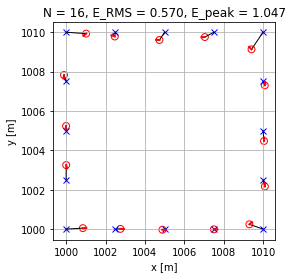

In [ ]:
# Ploteo la curva recorrida del robot vs la curva deseada
N = trajectory.shape[1]
fig,ax = plt.subplots(1)

# se plotea la curva deseada
ax.plot(trajectory[0,:],trajectory[1,:],'bx',linewidth=1)
# ax.plot(trajectory[0,:],trajectory[1,:],'b-',linewidth=1)
curva_aux = np.array(curva_recorrida)
# se plotea la curva seguida por el robot
#ax.plot(curva_aux[:,0],curva_aux[:,1],'r-',linewidth = 1)
#ax.plot(curva_aux[:,0],curva_aux[:,1],'rx',markersize = 5)

for i in range(0,N):
    ax.plot([trajectory[0,:][i],curva_aux[:,0][i]],[trajectory[1,:][i],curva_aux[:,1][i]],'k',linewidth = 1)

    pose_del_robot = curva_aux[i]

    plotear_robot(ax,pose_del_robot[0],pose_del_robot[1],pose_del_robot[2],robot.diameter/2,'r')


ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_aspect('equal')
ax.set_title('N = %i, E_RMS = %.3f, E_peak = %.3f' %(N, E_RMS, E_peak))
ax.grid(True)

In [ ]:
# Ploteo la curva recorrida del robot vs las referencias generadas por la red
N = trajectory.shape[1]
fig,ax = plt.subplots(1)

# se plotea la curva deseada
# ax.plot(trajectory[0,:],trajectory[1,:],'bx',linewidth=1)
# ax.plot(trajectory[0,:],trajectory[1,:],'b-',linewidth=1)
curva_aux = np.array(curva_recorrida)
# se plotea la curva seguida por el robot
#ax.plot(curva_aux[:,0],curva_aux[:,1],'r-',linewidth = 1)
#ax.plot(curva_aux[:,0],curva_aux[:,1],'rx',markersize = 5)
referencias = robot.get_references_DNN()

for i in range(0,N):
    # ax.plot([trajectory[0,:][i],curva_aux[:,0][i]],[trajectory[1,:][i],curva_aux[:,1][i]],'k',linewidth = 1)

    pose_del_robot = curva_aux[i]

    plotear_robot(ax,pose_del_robot[0],pose_del_robot[1],pose_del_robot[2],robot.diameter/2,'r')

for i in range(0,len(referencias)):
  ax.plot(referencias[i][0],referencias[i][1],'go',linewidth=1)

  ax.plot([curva_aux[:,0][i],referencias[i][0]],[curva_aux[:,1][i],referencias[i][1]],'k-',linewidth=1)

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_aspect('equal')
ax.set_title('N = %i, E_RMS = %.3f, E_peak = %.3f' %(N, E_RMS, E_peak))
ax.grid(True)

In [ ]:
L = 0
puntos = N
for k in range(0,puntos-1):
  delta_L = np.linalg.norm(trajectory[0:2,k+1] - trajectory[0:2,k])
  L = L + delta_L

print(L/(1.5*puntos))
print(L)

In [ ]:
referencias[48]

In [ ]:
aux = 0
for i in range(1,52):
 print(np.linalg.norm(trajectory[0:2,i-1] - trajectory[0:2,i]))

In [ ]:
print(np.linalg.norm(trajectory[:,1] - trajectory[:,2]))

In [ ]:
curva_recorrida[48]

In [ ]:
calculate_references(referencias[48],curva_recorrida[48])

In [ ]:
# Celda para guardar el gráfico de la curva en una imagen
fig.savefig('DNN_L.png',dpi = 300)

In [ ]:
# Gráfico de la curva recorrida vs curva deseada

fig, ax = plt.subplots(1)

ax.plot(trajectory[0,:],trajectory[1,:],'b-',linewidth=1)
ax.plot(curva_aux[:,0],curva_aux[:,1],'r-',linewidth = 1)

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_aspect('equal')
ax.grid(True)

In [ ]:
fig.savefig('test.png',dpi = 300)

In [ ]:
print(robot.get_simulation_time_mobile_robot())
print(robot.get_simulation_time_control())

78.30000000000001
78.0


In [ ]:
robot.stop_simulation()

Robot: simulation stopped
Control: simulation stopped


In [ ]:
curva_recorrida[13]

In [ ]:
trajectory[:,14]

In [ ]:
c = curva_recorrida
d = trajectory
#N = np.shape(d)[1]
N = 45
e = 0
e_peak = 0

for i in range(N):
    c_aux = np.array(c[i][0:2])
    # c_aux.shape = (2,1)
    e_new = np.linalg.norm(c_aux - d[0:2,i])
    
    if(e_new > e_peak):
        e_peak = e_new
        
    e = e + e_new**2
    # e_peak

e = e / N

e_rms = np.sqrt(e)

print(e_rms)

0.9552552519507084
